In [2]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pprint

tfk = tf.keras
tfkl = tfk.layers

## Load and preprocess the "Two moons" dataset

Create the "two moons" dataset and normalize into [-1, -1] ranges.

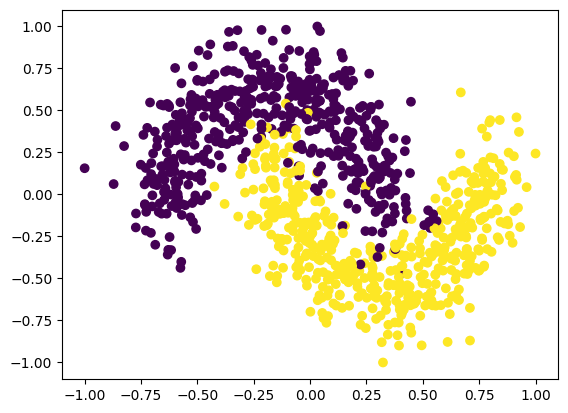

In [3]:
x_train, y_train = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=None)
x_test, y_test = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=None)


x_train[:, 0] = (x_train[:, 0] - min(x_train[:, 0])) / max(x_train[:, 0] - min(x_train[:, 0])) * 2 - 1
x_train[:, 1] = (x_train[:, 1] - min(x_train[:, 1])) / max(x_train[:, 1] - min(x_train[:, 1])) * 2 - 1

x_test[:, 0] = (x_test[:, 0] - min(x_test[:, 0])) / max(x_test[:, 0] - min(x_test[:, 0])) * 2 - 1
x_test[:, 1] = (x_test[:, 1] - min(x_test[:, 1])) / max(x_test[:, 1] - min(x_test[:, 1])) * 2 - 1

plt.scatter(x_train[:,0], x_train[:,1], c=y_train)

## Define models

We define a simple MLP as our baseline and a number of KANs.

In [7]:
from arnold.layers.polynomial.orthogonal import (
    Chebyshev1st,
    Legendre, 
)

from arnold.layers.wavelet import (
    Bump
)

In [45]:
all_models = {
    'mlp': tfk.Sequential([
            tfkl.Dense(50, activation="relu"),
            tfkl.Dense(50, activation="relu"),
            tfkl.Dense(1, activation="sigmoid")
        ],
        name='mlp'
    ),
    'fancy_kan': tfk.Sequential([
            Chebyshev1st(input_dim=2, output_dim=8, degree=2),
            tfkl.LayerNormalization(),
            Legendre(input_dim=8, output_dim=6, degree=3),
            tfkl.LayerNormalization(),
            Bump(input_dim=6, output_dim=1),
            tfkl.Activation(tfk.activations.sigmoid)
        ],
        name="fancy_kan" 
    )
}

## Train all models

Build and compile all models. 

In [46]:
for name, model in tqdm(all_models.items()):
    model.build((None, 2))
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

print('Trainable parameter', {name: np.sum([np.prod(p.shape) for p in model.trainable_weights]) for (name, model) in all_models.items()})
print('Non-trainable parameter', {name: np.sum([np.prod(p.shape) for p in model.non_trainable_weights]) for (name, model) in all_models.items()})

100%|██████████| 2/2 [00:00<00:00, 32.26it/s]

Trainable parameter {'mlp': 2751, 'fancy_kan': 286}
Non-trainable parameter {'mlp': 0.0, 'fancy_kan': 0.0}


Train all models. On a Apple M1 Max this will take ~5 minutes.

In [47]:
EPOCHS = 20

In [48]:
model_train_histories = {
    name: model.fit(
        x_train,
        np.reshape(y_train, (-1,1)),
        epochs=EPOCHS, 
        shuffle=True,
        verbose=1
    ) for (name, model) in all_models.items()
}

Epoch 1/20


32/32 [==============================] - 0s 745us/step - loss: 0.6417 - binary_accuracy: 0.7390
Epoch 2/20
32/32 [==============================] - 0s 778us/step - loss: 0.4773 - binary_accuracy: 0.8640
Epoch 3/20
32/32 [==============================] - 0s 685us/step - loss: 0.3508 - binary_accuracy: 0.8640
Epoch 4/20
32/32 [==============================] - 0s 592us/step - loss: 0.3141 - binary_accuracy: 0.8700
Epoch 5/20
32/32 [==============================] - 0s 624us/step - loss: 0.3010 - binary_accuracy: 0.8740
Epoch 6/20
32/32 [==============================] - 0s 614us/step - loss: 0.2924 - binary_accuracy: 0.8790
Epoch 7/20
32/32 [==============================] - 0s 598us/step - loss: 0.2856 - binary_accuracy: 0.8790
Epoch 8/20
32/32 [==============================] - 0s 587us/step - loss: 0.2765 - binary_accuracy: 0.8810
Epoch 9/20
32/32 [==============================] - 0s 593us/step - loss: 0.2680 - binary_accuracy: 0.8850
Epoch 10/20
32/32 [=============================

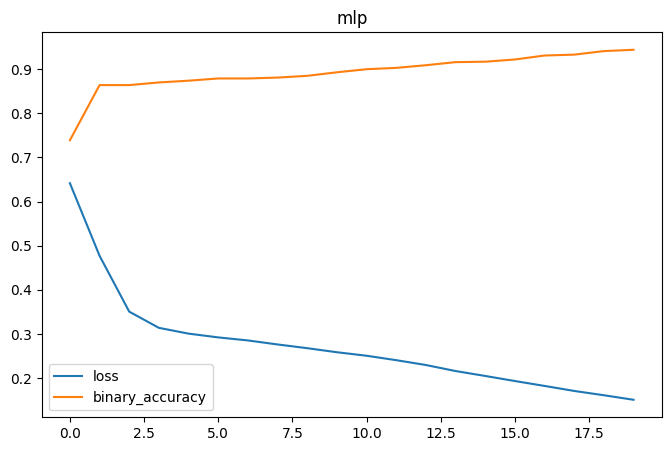

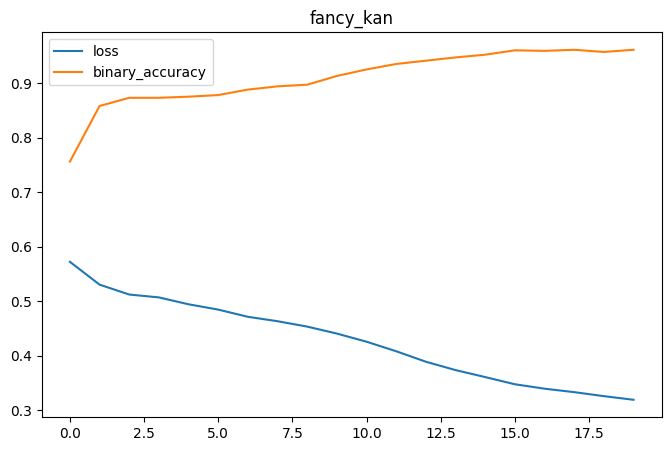

In [49]:
import pandas as pd

for name, hist in model_train_histories.items():
    pd.DataFrame(hist.history).plot(figsize=(8,5), title=name)
    plt.show()

In [50]:
y_true = y_test

all_predictions = { 
    name: np.round(model.predict(x_test)).flatten() for (name, model) in tqdm(all_models.items())
}

  0%|          | 0/2 [00:00<?, ?it/s]

32/32 [==============================] - 0s 592us/step


100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


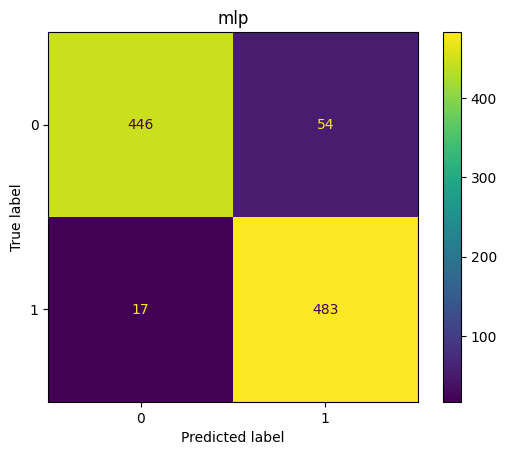

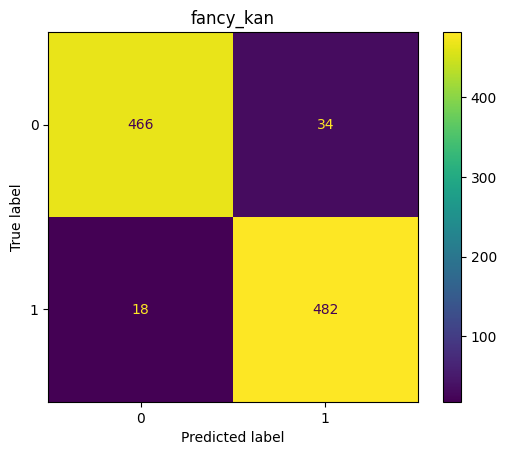

In [51]:
for name, y_pred in all_predictions.items():
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            y_true,
            y_pred,
        )
    )
    disp.plot()
    disp.ax_.set_title(name)